# Categorization Models

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import datasets, model_selection, metrics
from sklearn import linear_model, naive_bayes, tree
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# Importing the Data
df = pd.read_csv("Post_EDA_encoded_df.csv")
df.head()

,Sentiment_Score,Is_Response,Has_WebLink,Email_Length,accentChar_Count,accentChar_percentage,Hyphen_Count,Pound_Count,At_Count,Exclamation_Count,Question_Count,Period_Count,Exclamation_Percentage,Question_Percentage,Period_Percentage,Hyphen_Percentage,Pound_Percentage,At_Percentage,Capitalization_Percent,Safe_Email
0,0.9798,True,False,1030,0,0.0,1,0,0,2,0,7,0.194175,0.000000,0.679612,0.097087,0.000000,0.000000,0.000,1
1,0.4329,False,False,479,0,0.0,0,0,1,0,2,4,0.000000,0.417537,0.835073,0.000000,0.000000,0.208768,0.000,1
2,0.8591,True,False,1245,0,0.0,51,2,3,0,1,6,0.000000,0.080321,0.481928,4.096386,0.160643,0.240964,0.000,1
3,0.9640,False,True,688,0,0.0,14,0,0,1,1,36,0.145349,0.145349,5.232558,2.034884,0.000000,0.000000,9.375,0
4,0.0534,False,False,441,0,0.0,0,0,0,0,0,13,0.000000,0.000000,2.947846,0.000000,0.000000,0.000000,0.000,0


Standardization (or scaling) of data is a crucial preprocessing step. It does not change the underlying relationships between the features, but it scales them for comparability. I was having issues with convergence until the data was scaled.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Scale the data
X = df.drop(['Safe_Email'], axis=1)
y = df['Safe_Email']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified K-Fold due to imbalanced classes


# Splitting the Data, Training versus Testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.3)

X_train_pct = round((len(X_train) / (len(X_train) + len(X_test))), 2)
X_test_pct = round((len(X_test) / (len(X_train) + len(X_test))), 2)

print('Classification training dataset shape is:', X_train.shape, 'Testing dataset shape is:', X_test.shape)
print('Regression train/test split is:', X_train_pct, '/', X_test_pct)

Classification training dataset shape is: (12670, 19) Testing dataset shape is: (5431, 19)
Regression train/test split is: 0.7 / 0.3


## Logistic Regression

In [9]:
logistic_model = linear_model.LogisticRegression()

# Train the model
logistic_model.fit(X_train,y_train)
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.7459031485914196
Precision: 0.7232864066466651
Recall: 0.9453996983408748
F1 Score: 0.819560669456067


## Models From the Categorization Example on Blackboard

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd

param_dict = {
    'knn': ('n_neighbors', [2, 3, 4, 5, 6, 7, 8], 'weights', ['uniform', 'distance']),
    'svc': ('C', [1, 2], 'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'dt': ('criterion', ['gini', 'entropy', 'log_loss'], 'max_depth', [2, 3, 4, 5, 6]),
    'rf': ('n_estimators', [50, 100, 150, 200], 'max_depth', [2, 3, 4, 5, 6]),
    'mlp': ('activation', ['identity', 'logistic', 'tanh', 'relu'], 'solver', ['lbfgs', 'sgd', 'adam']),
    'lrm': ('penalty', ['l2'], 'C', [0.1, 1, 5, 10], 'solver', ['liblinear', 'newton-cg'])
}

model_dict = {
    'knn': KNeighborsClassifier(),
    'svc': SVC(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'mlp': MLPClassifier(),
    'lrm': linear_model.LogisticRegression(max_iter=1000)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

summary = []
cm_df = pd.DataFrame()

for i in ['knn', 'svc', 'dt', 'rf', 'mlp','lrm']:
    param_grid = list(itertools.product(param_dict[i][1], param_dict[i][3]))
    for k in range(len(param_grid)):
        param_grid_dict = {param_dict[i][0]: param_grid[k][0], param_dict[i][2]: param_grid[k][1]}
        model = model_dict[i]
        
        for train_index, test_index in skf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.set_params(**param_grid_dict)
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            summary.append([i, param_dict[i][0], param_grid[k][0], param_dict[i][2], param_grid[k][1],
                            accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'),
                            recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')])
            
            dfpred = pd.DataFrame([y_pred]).transpose()
            dftest = pd.DataFrame([y_test]).transpose()
            cm_data_temp = pd.concat([dfpred, dftest], axis=1)
            cm_df = pd.concat([cm_df, cm_data_temp], axis=0)

summary_df = pd.DataFrame(summary, columns=('model', 'param1', 'parval1', 'param2', 'parval2', 'accuracy', 'precision', 'recall', 'f1'))
best_df = summary_df.nlargest(15, 'f1')
cm_df.columns = ('ypred', 'ytest')

best_df


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: Co

,model,param1,parval1,param2,parval2,accuracy,precision,recall,f1
331,mlp,activation,relu,solver,lbfgs,0.851381,0.845900,0.837787,0.841356
45,knn,n_neighbors,6,weights,distance,0.848937,0.843065,0.835577,0.838896
46,knn,n_neighbors,6,weights,distance,0.846961,0.840869,0.833523,0.836783
55,knn,n_neighbors,7,weights,distance,0.847004,0.841365,0.832936,0.836617
68,knn,n_neighbors,8,weights,distance,0.846961,0.841749,0.832186,0.836296
334,mlp,activation,relu,solver,lbfgs,0.845856,0.839019,0.833613,0.836081
35,knn,n_neighbors,5,weights,distance,0.845899,0.839426,0.832971,0.835872
341,mlp,activation,relu,solver,adam,0.848343,0.847669,0.828496,0.835786
343,mlp,activation,relu,solver,adam,0.848066,0.847292,0.828271,0.835514
58,knn,n_neighbors,7,weights,distance,0.846133,0.840711,0.831511,0.835484


### Confusion Matrix

In [11]:
missing_values_count = cm_df['ytest'].isna().sum()
print("Number of missing values in 'ytest' column:", missing_values_count)

Number of missing values in 'ytest' column: 1057040


In [24]:
missingValuesNaN = round(1057040/cm_df.shape[0]*100,4)
print("Unfortunately,", missingValuesNaN, "percent of the models did not converge.")
# Drop rows with NaN values in 'ytest' column
cm_df = cm_df.dropna(subset=['ytest','ypred'])

# Reset the index after dropping rows
cm_df = cm_df.reset_index(drop=True)


Unfortunately, 79.9956 percent of the models did not converge.


In [25]:
cm_matrix = confusion_matrix(cm_df['ytest'], cm_df['ypred'])
print(cm_matrix)

[[ 28387  75346]
 [ 44662 115938]]


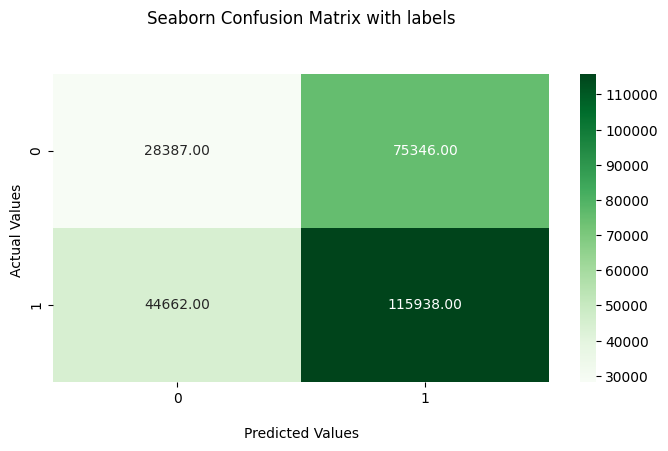

In [29]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,4))

ax = sns.heatmap(cm_matrix, annot=True, cmap='Greens', fmt='.2f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

Here we see that our model is more likely to give a false negative than a false positive.

## Interpretation of the results

### Data
In our analysis and preperation of the dataset there was an implicit assumption that features like special characters and the presence of a URL will be good predictors of phishing and spam emails. 

### Results
No matter what modeling technique is used the results are disappointing.
The best model has an accuracy of 0.851381,precision of	0.845900, and a recall of	0.837787. A quick glance at the confusion matrix will make clear that false positives and negatives are common. Another clear indicator of this failure is that 10 of the 15 best models of all of the possible models we tried were "dumb learning" k nearest neighbor models.

### Comparison to NLP Approach
The Natural Language Processing technique of tokenisation (seperating the email text into key words) followed by vectorization (assigning numbers to those tokens) provides a much better foundation for applying machine learning techniques. The following section applies this approach to our dataset.

## NLP Comparison

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load the data
df = pd.read_csv("Sentiment_Analysis_Export_df.csv")

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the text
tfidf_vectorizer.fit(df["Tokenized_Text"])

# Transforming tokenized text into TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.transform(df["Tokenized_Text"])

# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Fitting the logistic regression model, "Email Type is the target variable"
logistic_model.fit(tfidf_vectors, df["Email Type"])


# Define the selected configurations
selected_configurations = [
    {'penalty': 'l1', 'C': 5.0, 'solver': 'liblinear'},
    {'penalty': 'l1', 'C': 0.5, 'solver': 'liblinear'},
    {'penalty': 'l2', 'C': 5.0, 'solver': 'liblinear'},
    {'penalty': 'l2', 'C': 10.0, 'solver': 'newton-cg'}
]


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize an empty list to store confusion matrices
conf_matrices = []

summary = []

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for config in selected_configurations:
    for train_index, test_index in skf.split(tfidf_vectors, df["Email Type"]):
        X_train, X_test = tfidf_vectors[train_index], tfidf_vectors[test_index]
        y_train, y_test = df["Email Type"][train_index], df["Email Type"][test_index]
        
        model = LogisticRegression(**config)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Store the results as a dictionary
        result = {
            'Param1': config['penalty'],
            'Parval1': config['C'],
            'Param2': 'solver',
            'Parval2': config['solver'],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
        summary.append(result)

# Convert the list of dictionaries to a DataFrame
summary_df = pd.DataFrame(summary, columns=('Param1', 'Parval1', 'Param2', 'Parval2', 'Accuracy', 'Precision', 'Recall', 'F1'))

# Compute average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Display the average confusion matrix
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Display the results
best_nlpDF = summary_df.nlargest(5, "F1")
print(best_nlpDF)

Average Confusion Matrix:
[[1353.05   42.35]
 [  48.   2176.8 ]]
   Param1  Parval1  Param2    Parval2  Accuracy  Precision    Recall        F1
19     l2     10.0  solver  newton-cg  0.987845   0.987868  0.987845  0.987852
16     l2     10.0  solver  newton-cg  0.987293   0.987290  0.987293  0.987291
14     l2      5.0  solver  liblinear  0.986740   0.986757  0.986740  0.986746
18     l2     10.0  solver  newton-cg  0.986740   0.986738  0.986740  0.986731
13     l2      5.0  solver  liblinear  0.985912   0.985910  0.985912  0.985901


In [6]:
best_nlpDF

,Param1,Parval1,Param2,Parval2,Accuracy,Precision,Recall,F1
19,l2,10.0,solver,newton-cg,0.987845,0.987868,0.987845,0.987852
16,l2,10.0,solver,newton-cg,0.987293,0.987290,0.987293,0.987291
14,l2,5.0,solver,liblinear,0.986740,0.986757,0.986740,0.986746
18,l2,10.0,solver,newton-cg,0.986740,0.986738,0.986740,0.986731
13,l2,5.0,solver,liblinear,0.985912,0.985910,0.985912,0.985901


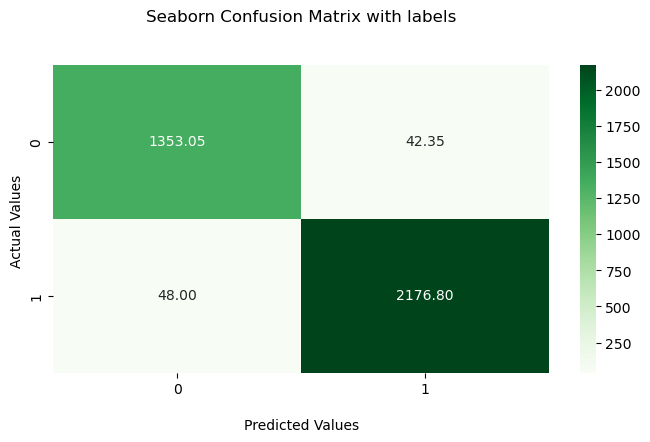

In [8]:
#importing seaborn again beacuse the other code block takes an hour to run
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,4))

ax = sns.heatmap(avg_conf_matrix, annot=True, cmap='Greens', fmt='.2f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [10]:
df.head(5)

,Email Text,Email Type,Tokenized_Text,Sentiment_Score
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,"['6', '1100', 'disc', 'uniformitarianism', '10...",0.9798
1,the other side of * galicismos * * galicismo *...,Safe Email,"['side', 'galicismos', 'galicismo', 'spanish',...",0.4329
2,re : equistar deal tickets are you still avail...,Safe Email,"['equistar', 'deal', 'ticket', 'still', 'avail...",0.8591
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,"['hello', 'hot', 'lil', 'horny', 'toy', 'one',...",0.9640
4,software at incredibly low prices ( 86 % lower...,Phishing Email,"['software', 'incredibly', 'low', 'price', '86...",0.0534


In [12]:
#features
X = df.drop(["Email Type"],axis=1)
#target
Y = df["Email Type"]

In [26]:
vData = tfidf_vectorizer.fit_transform(df['Email Text'])

In [27]:
#importing again because OG code block with these imports take over an hour to run
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(vData, Y, test_size=0.3, random_state=42)

In [29]:
# Define the models
models = {
    "Random Forest Classifier": RandomForestClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Multi-Layer Perceptron (MLP) Classifier": MLPClassifier(),
    "Support Vector Classification (SVC)": SVC()
}

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

The following code runs for around 41 minutes on my computer

In [30]:
# Iterate over models and print their scores
for name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"{name}:\n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

Random Forest Classifier:
 Accuracy: 0.9667, Precision: 0.9669, Recall: 0.9667, F1 Score: 0.9665

Decision Tree Classifier:
 Accuracy: 0.9160, Precision: 0.9159, Recall: 0.9160, F1 Score: 0.9159

K-Nearest Neighbors:
 Accuracy: 0.9426, Precision: 0.9432, Recall: 0.9426, F1 Score: 0.9427

Multi-Layer Perceptron (MLP) Classifier:
 Accuracy: 0.9873, Precision: 0.9873, Recall: 0.9873, F1 Score: 0.9873

Support Vector Classification (SVC):
 Accuracy: 0.9851, Precision: 0.9851, Recall: 0.9851, F1 Score: 0.9851

